# GJ436

In [1]:
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt

In [2]:
name = 'GJ436'

In [3]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))
obs = om.Observation.from_files(fnames)

/Users/ch/HST/projects/ombre/src/ombre/visit.py:208: RuntimeWarning: divide by zero encountered in true_divide
  w[self.err / self.sci > 0.1] = 1e10


In [4]:
import lightkurve as lk
import astropy.units as u
clc = lk.search_lightcurve(name, mission='TESS', author='SPOC', exptime=120).download_all().stitch().remove_nans()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

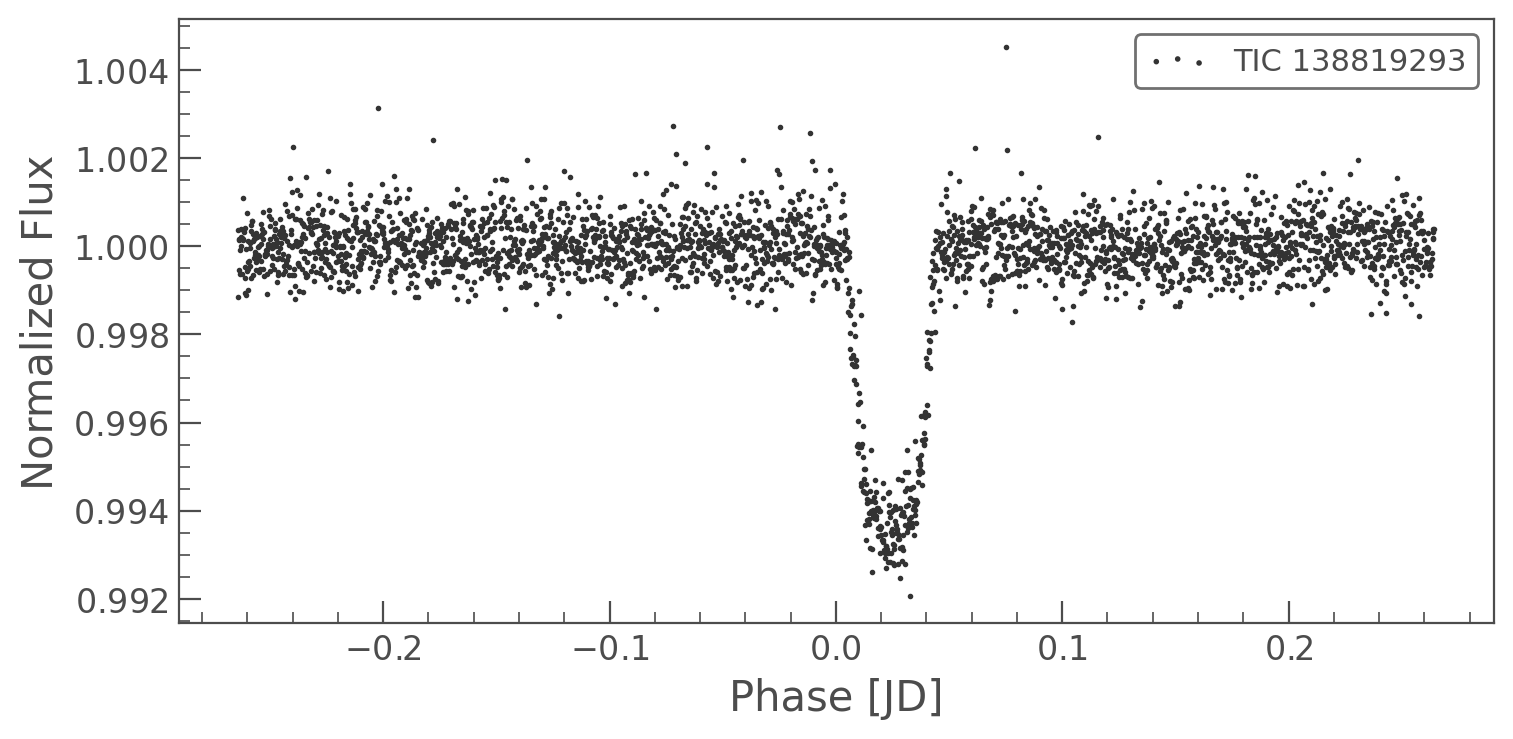

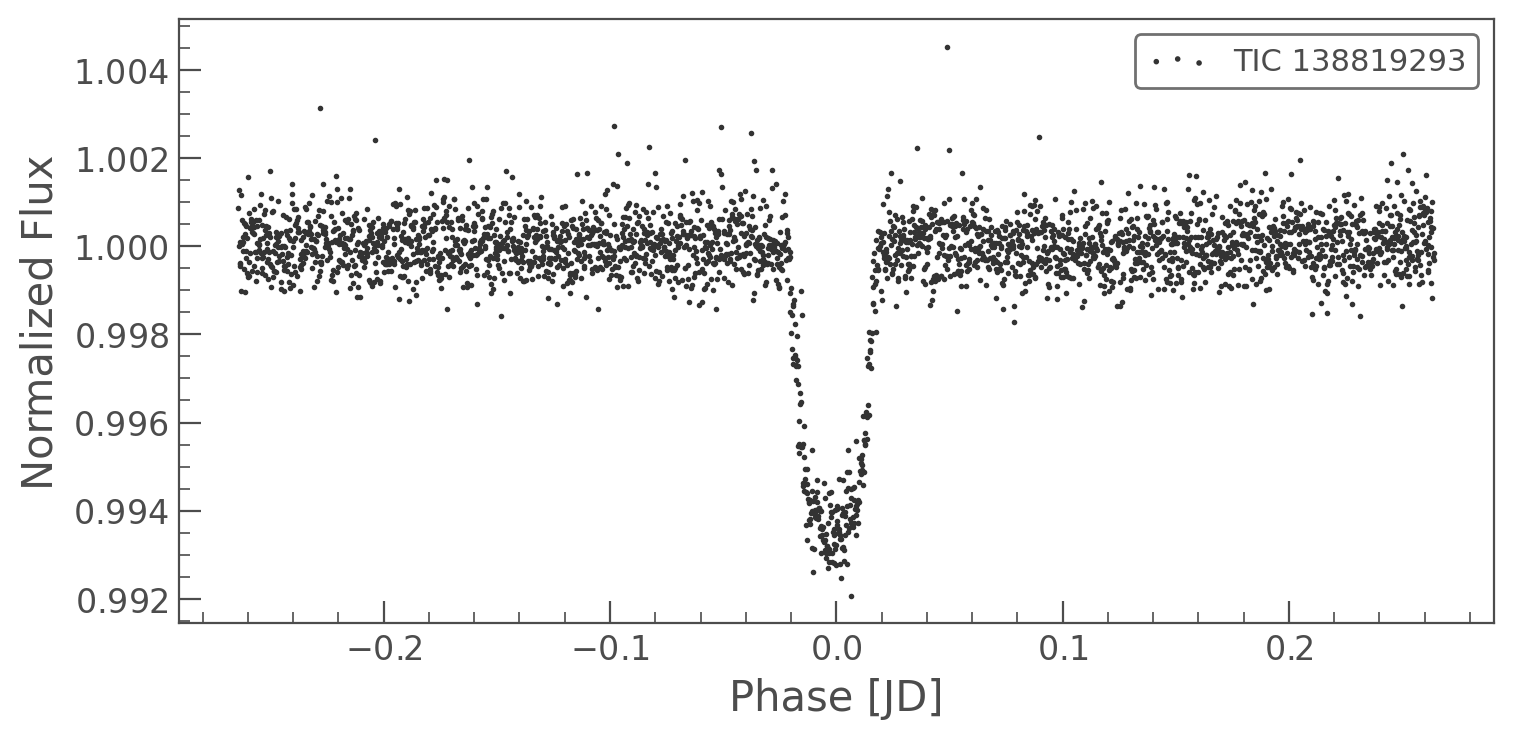

In [5]:
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

bls = clc.to_periodogram('bls', minimum_period=obs.period * 0.99, maximum_period=obs.period * 1.01, duration=obs.duration/24, frequency_factor=0.1)
obs.period, obs.t0 = bls.period_at_max_power.value, bls.transit_time_at_max_power.value + 2457000

k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()


In [6]:
obs

GJ-436 [8 Visits]

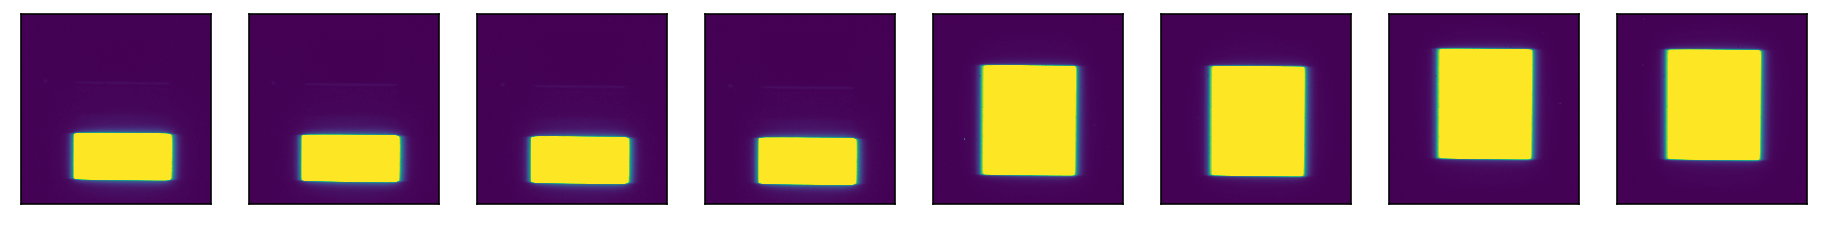

In [7]:
fig, ax = plt.subplots(1, len(obs), figsize=(len(obs) * 2, 2))
for idx, visit in enumerate(obs):
    ax[idx].imshow(visit.sci[0], vmin=0, vmax=1000)
    ax[idx].set(xticks=[], yticks=[])

In [8]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2457000,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=False, fit_inc=False)

In [9]:
obs.period = 2.64388312
obs.t0 = 2454865.084034

In [10]:
obs[-1]

GJ436 Visit 6, Forward False [Proposal ID: 13338]

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

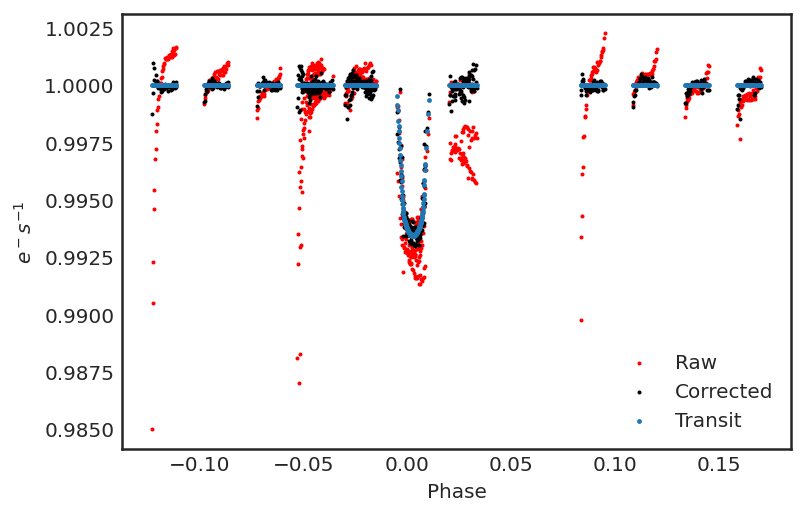

In [11]:
obs.plot()

In [12]:
obs.fit_model()

Fitting Transit/Eclipse Model:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting Transit/Eclipse Model:  12%|█▎        | 1/8 [00:18<02:07, 18.19s/it]

Fitting Transit/Eclipse Model:  25%|██▌       | 2/8 [00:36<01:48, 18.06s/it]

Fitting Transit/Eclipse Model:  38%|███▊      | 3/8 [00:55<01:32, 18.56s/it]

Fitting Transit/Eclipse Model:  50%|█████     | 4/8 [01:14<01:14, 18.63s/it]

Fitting Transit/Eclipse Model:  62%|██████▎   | 5/8 [01:41<01:05, 21.80s/it]

Fitting Transit/Eclipse Model:  75%|███████▌  | 6/8 [02:10<00:48, 24.43s/it]

Fitting Transit/Eclipse Model:  88%|████████▊ | 7/8 [02:40<00:26, 26.15s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 8/8 [03:10<00:00, 27.20s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 8/8 [03:10<00:00, 23.77s/it]

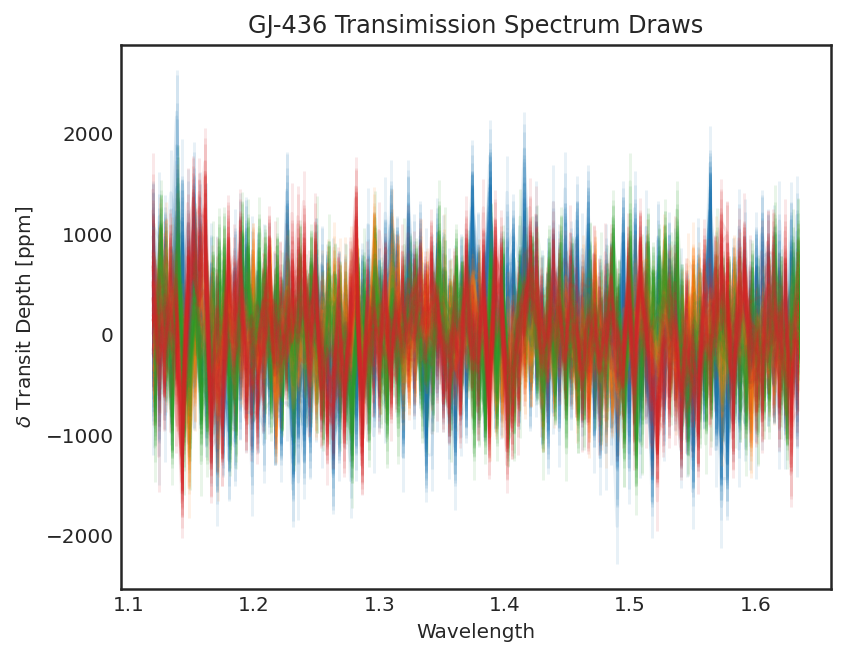

In [13]:
obs.plot_spectra()

/Users/ch/HST/projects/ombre/src/ombre/spec.py:92: RuntimeWarning: divide by zero encountered in true_divide
  y[idx] = np.average(self.spec[k], weights=1 / self.spec_err[k])
/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/Users/ch/HST/projects/ombre/src/ombre/spec.py:94: RuntimeWarning: divide by zero encountered in true_divide
  (self.spec[k] - y[idx]) ** 2, weights=1 / self.spec_err[k]


<AxesSubplot:title={'center':'GJ-436 Transmission Spectrum, Visit: 1'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

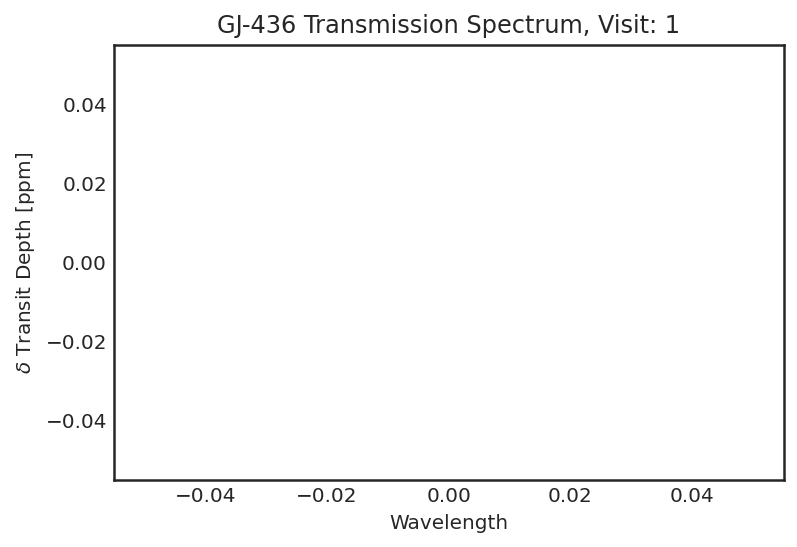

In [14]:
om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 200)).plot()

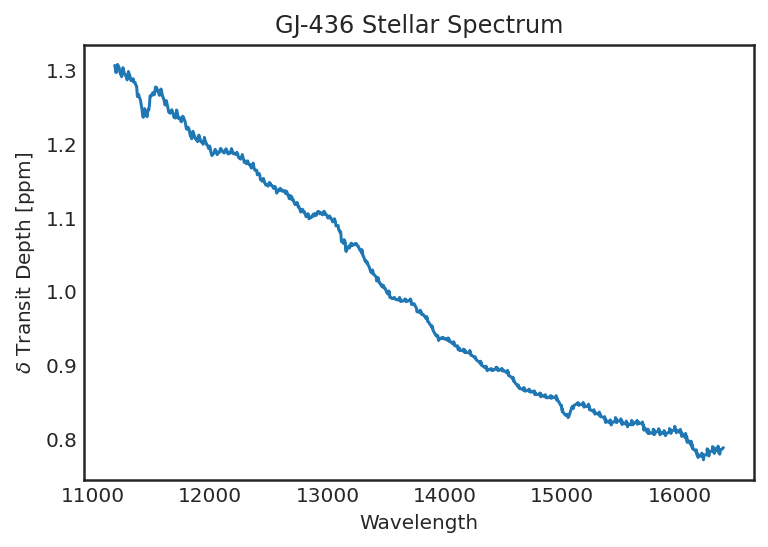

In [15]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

In [16]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

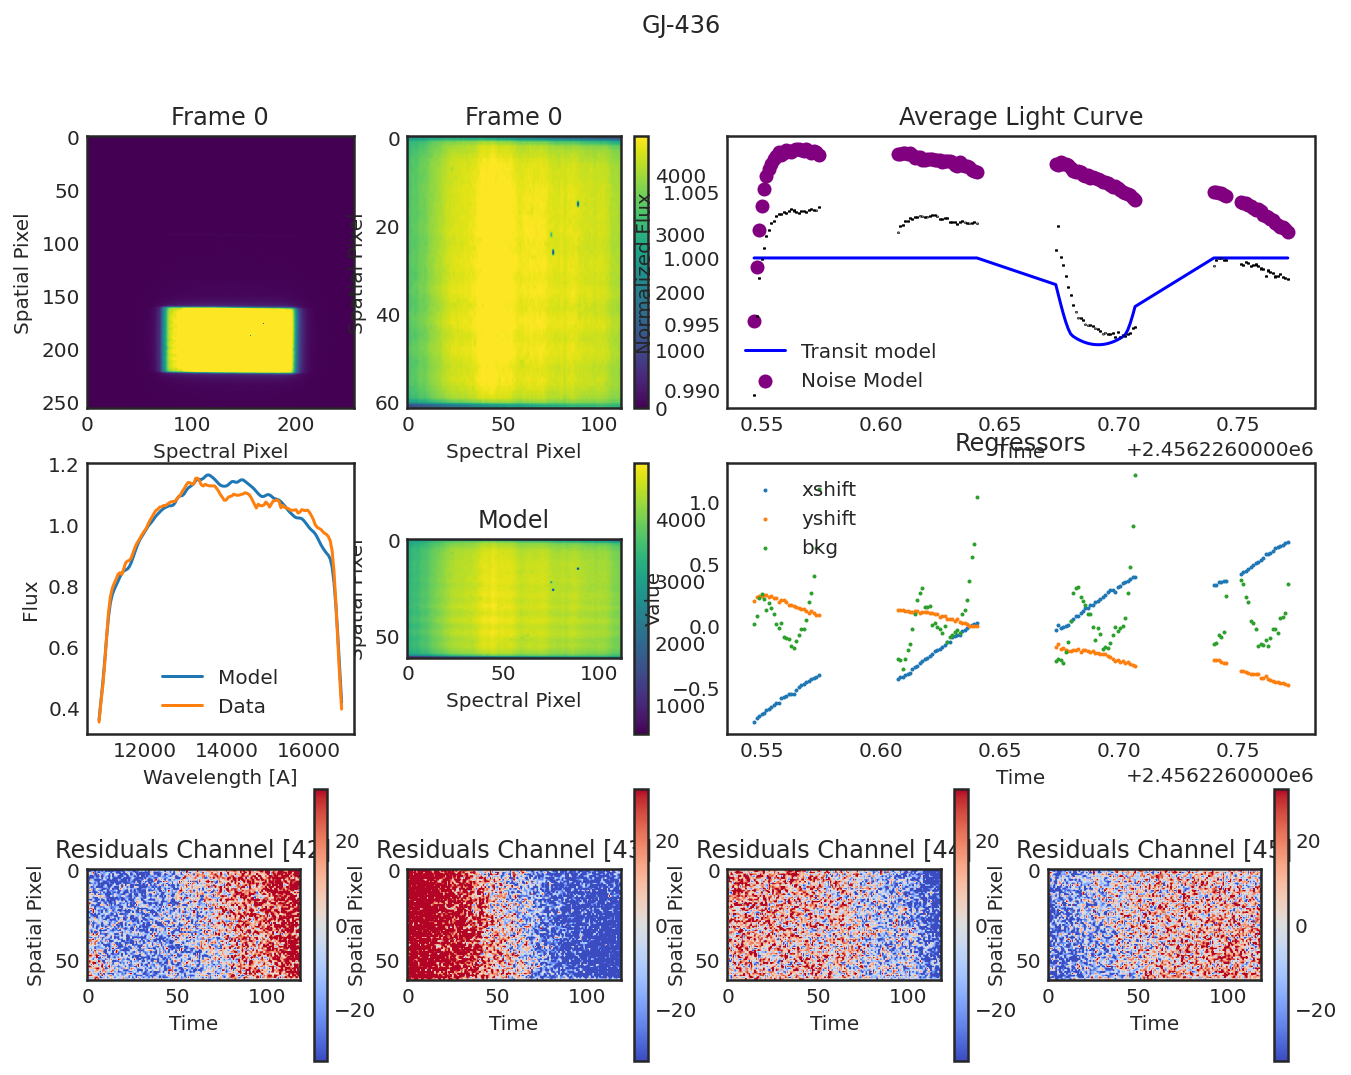

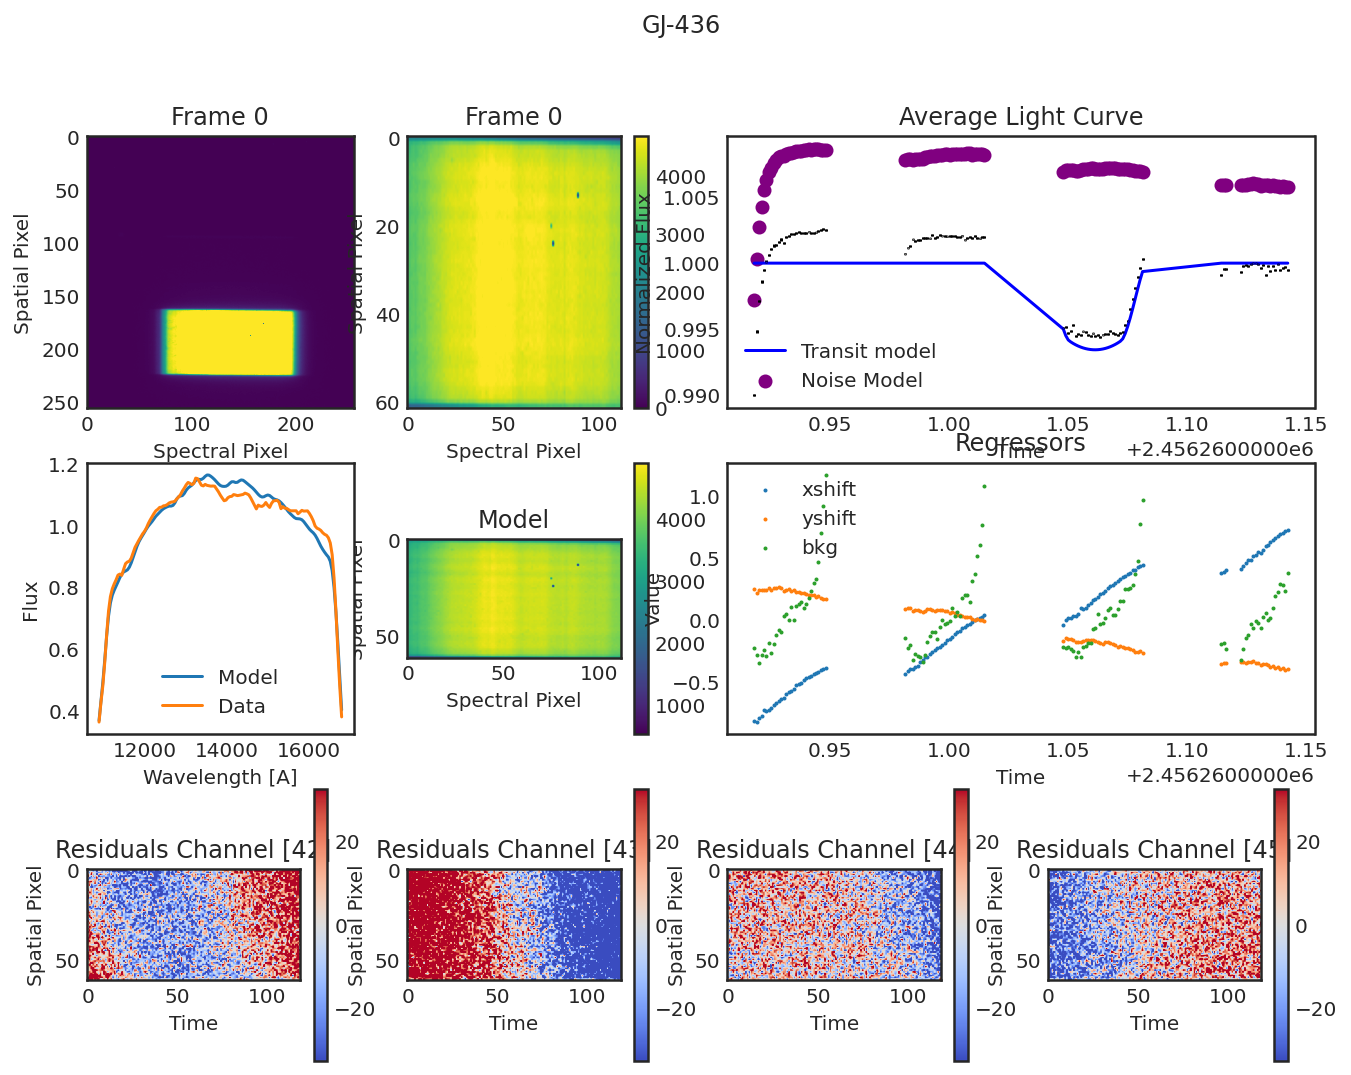

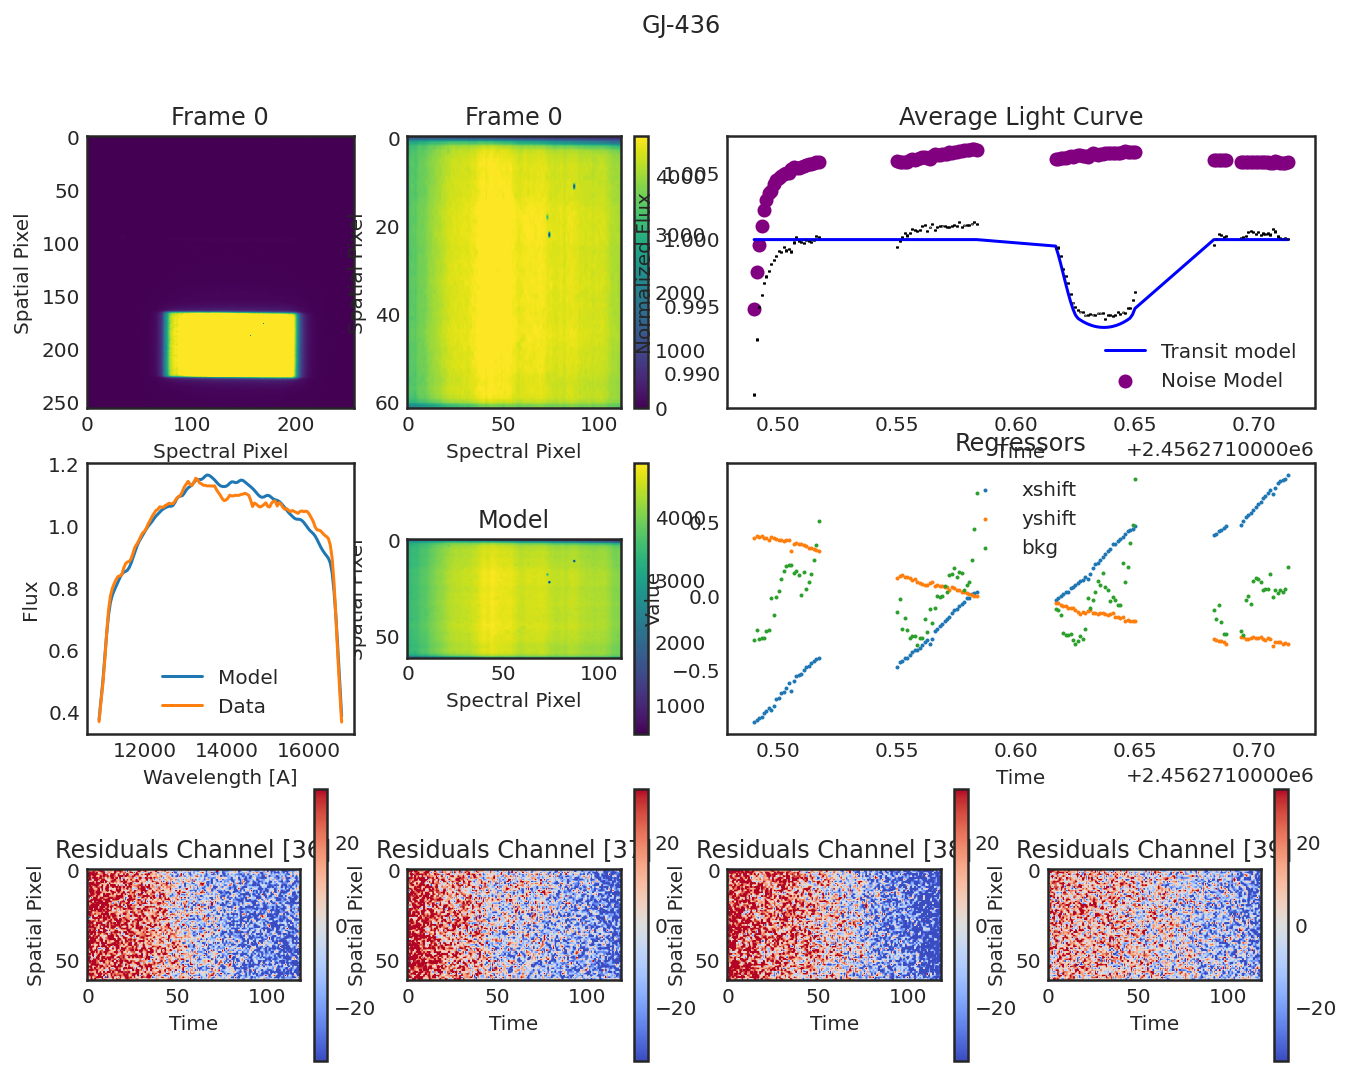

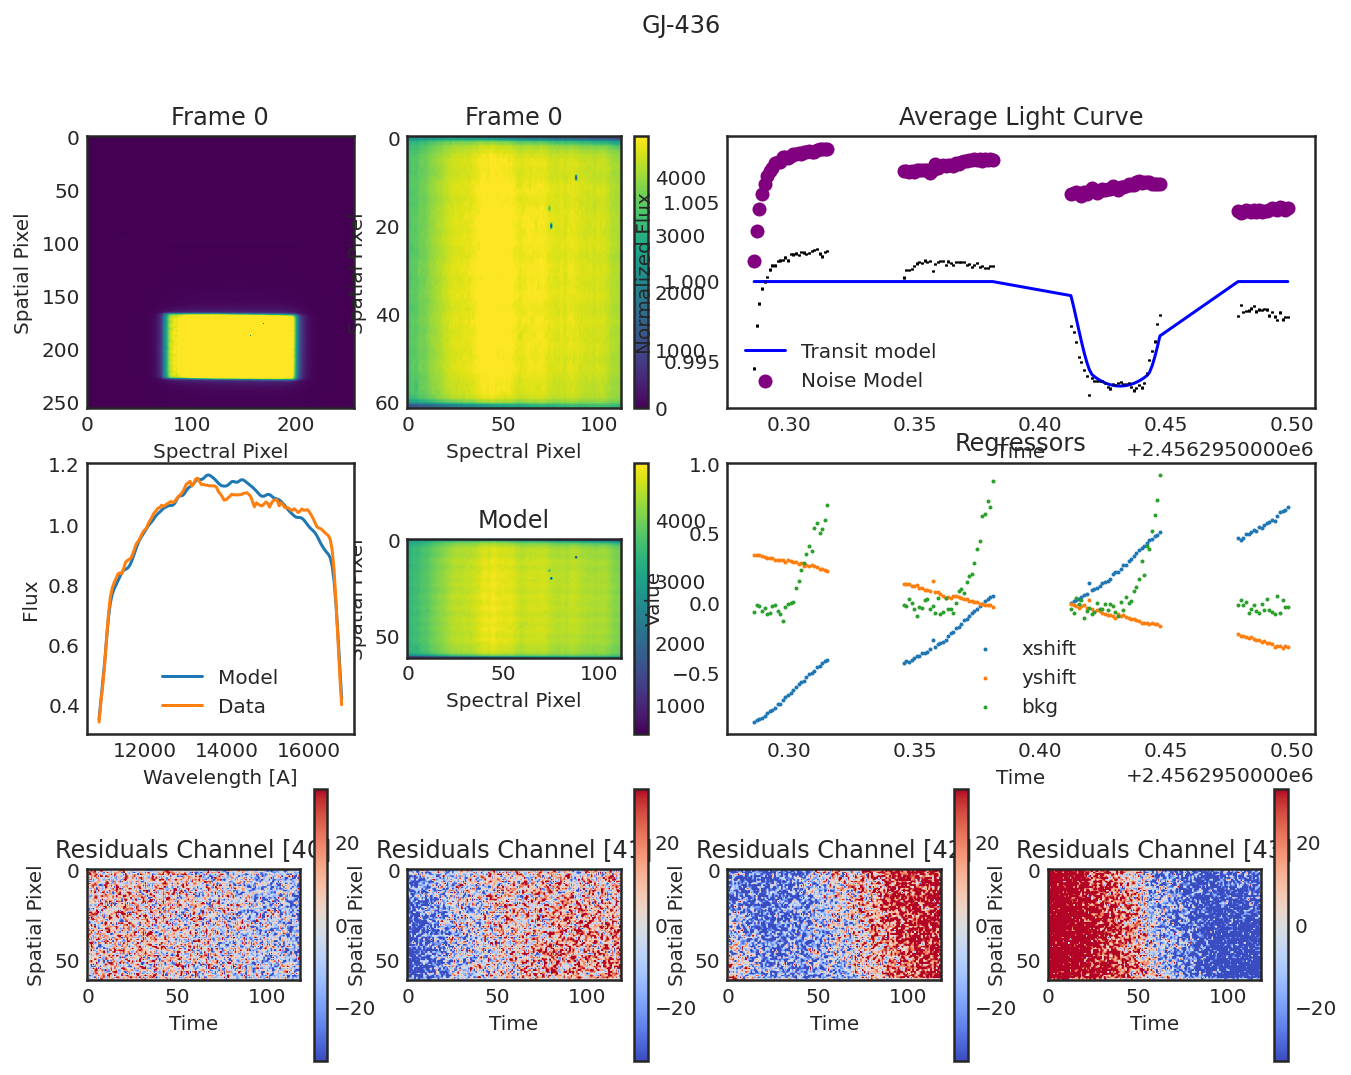

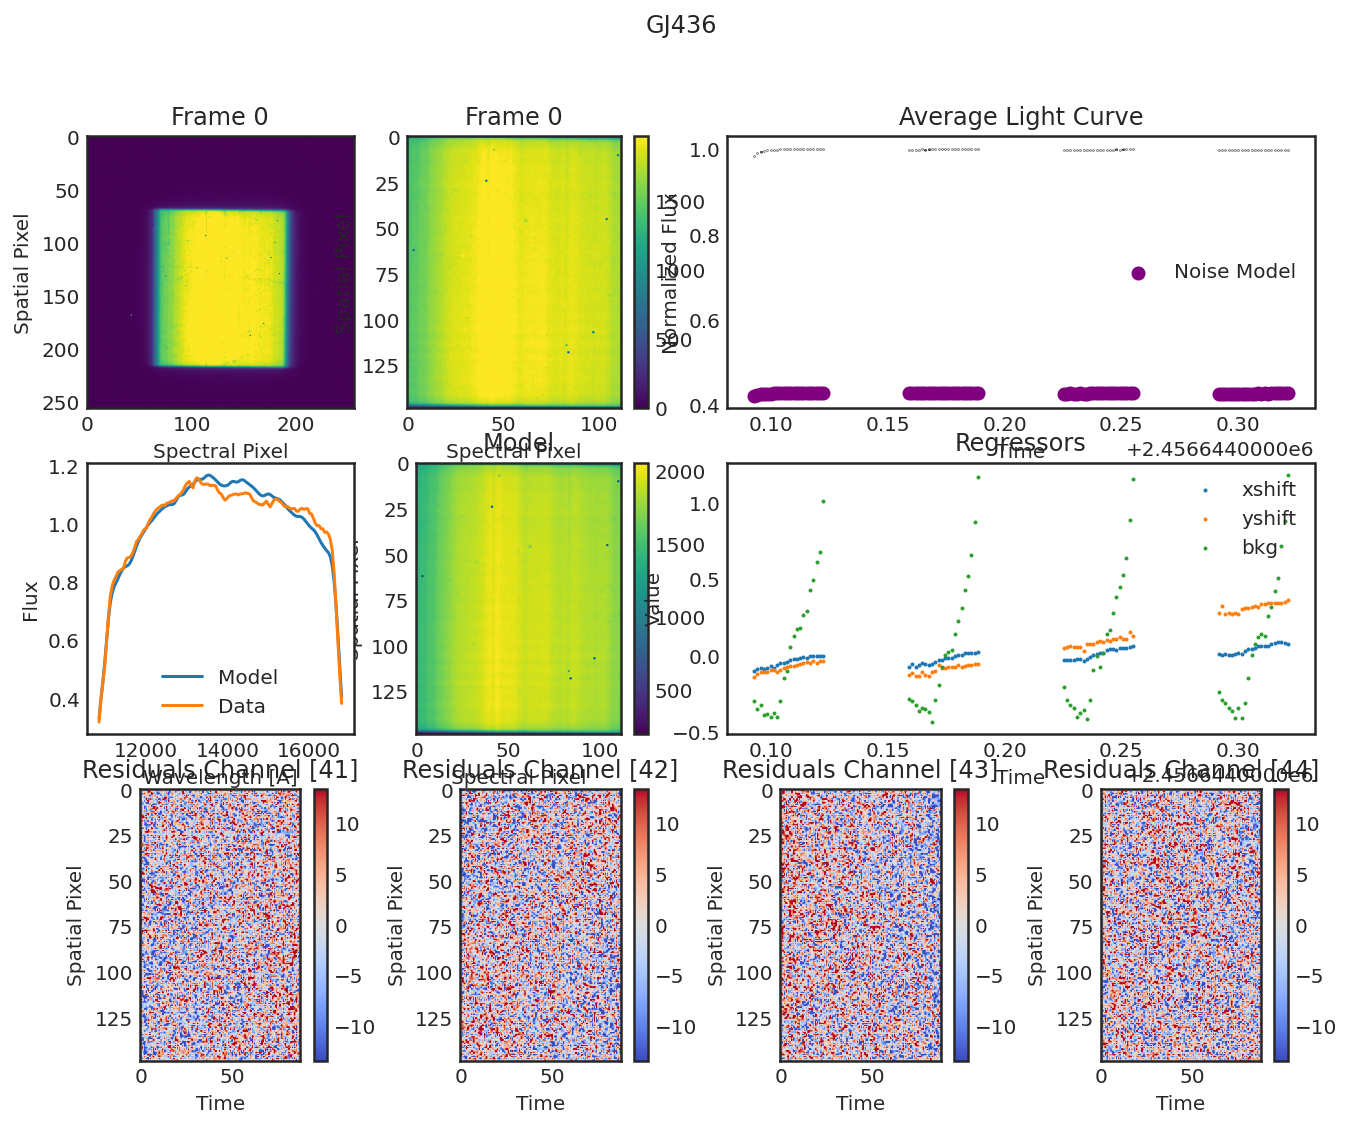

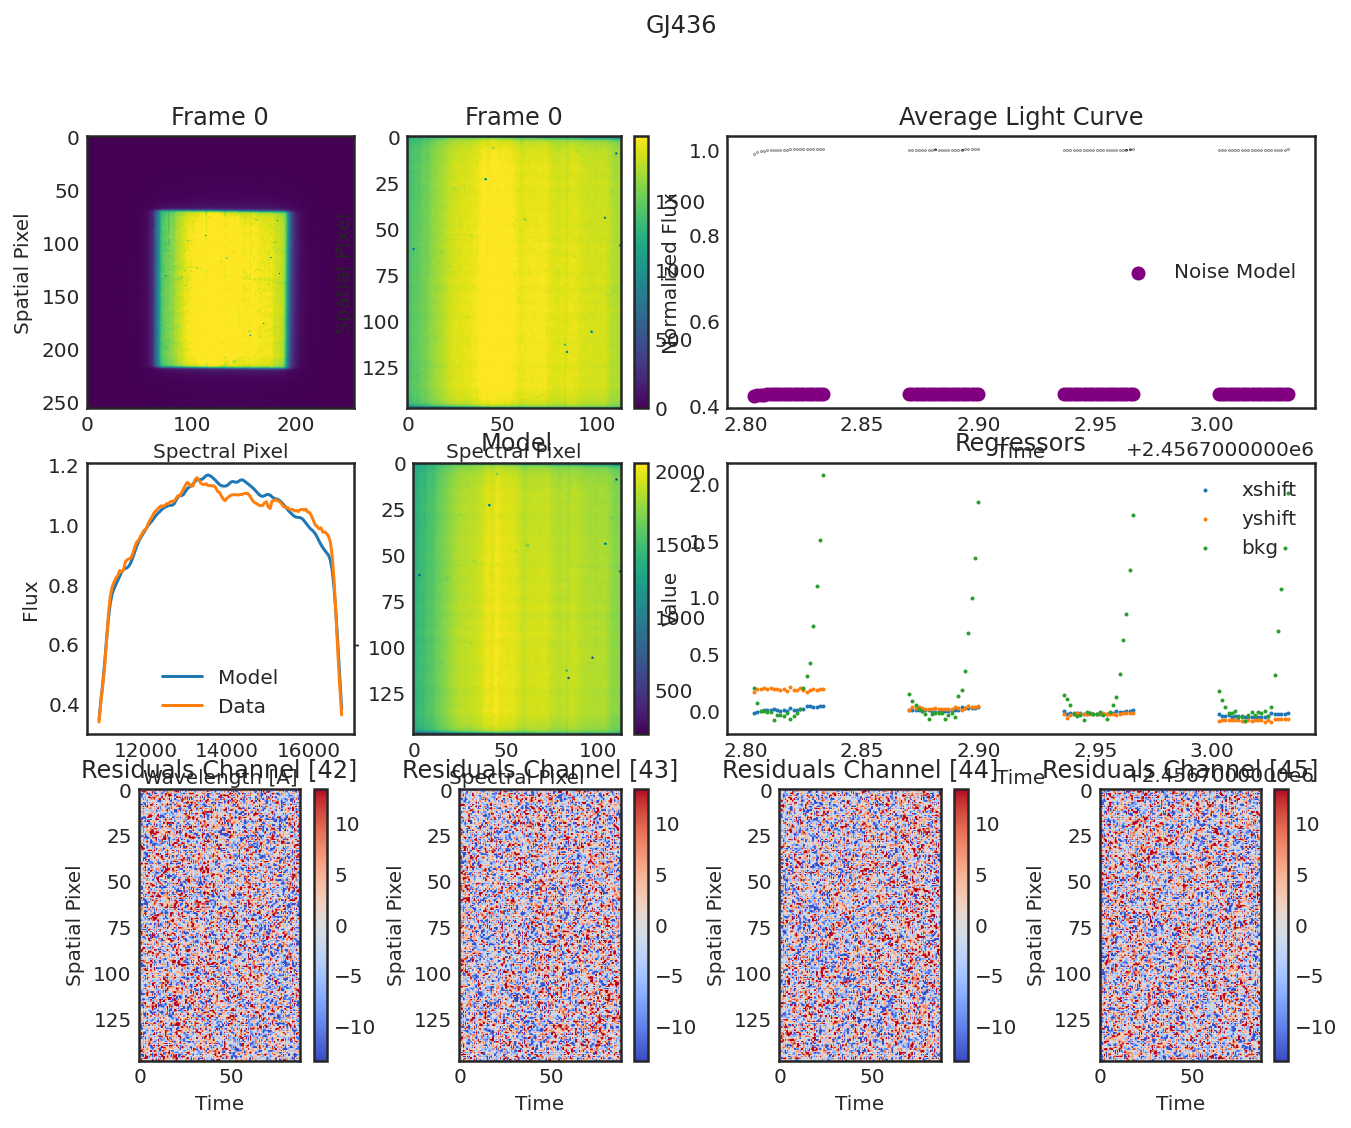

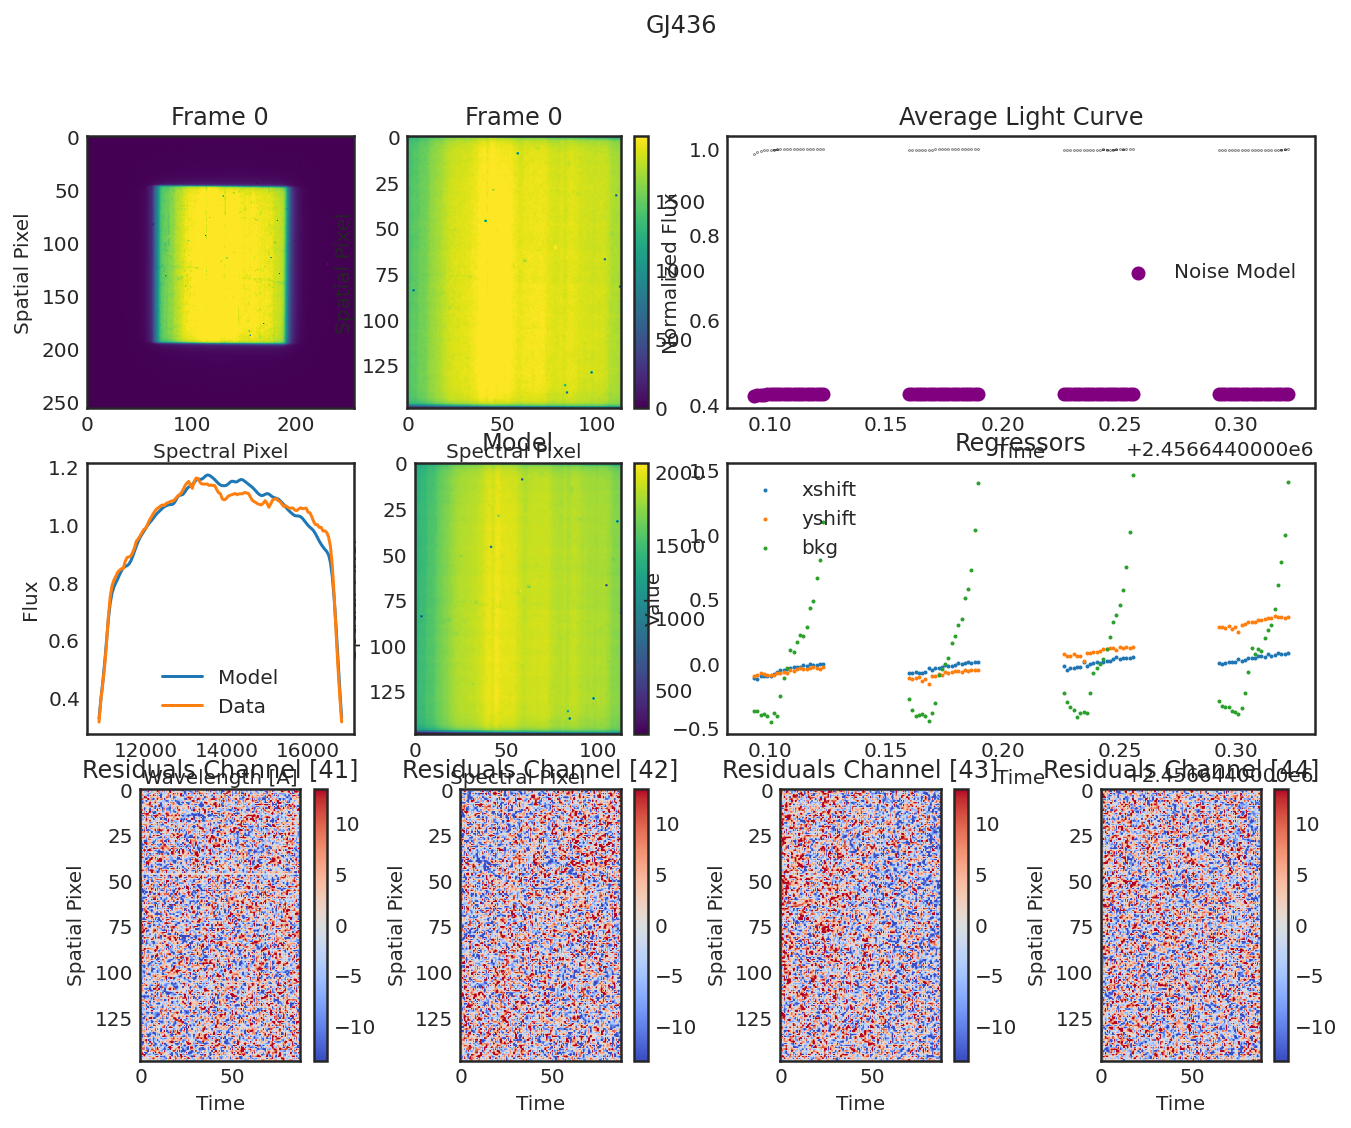

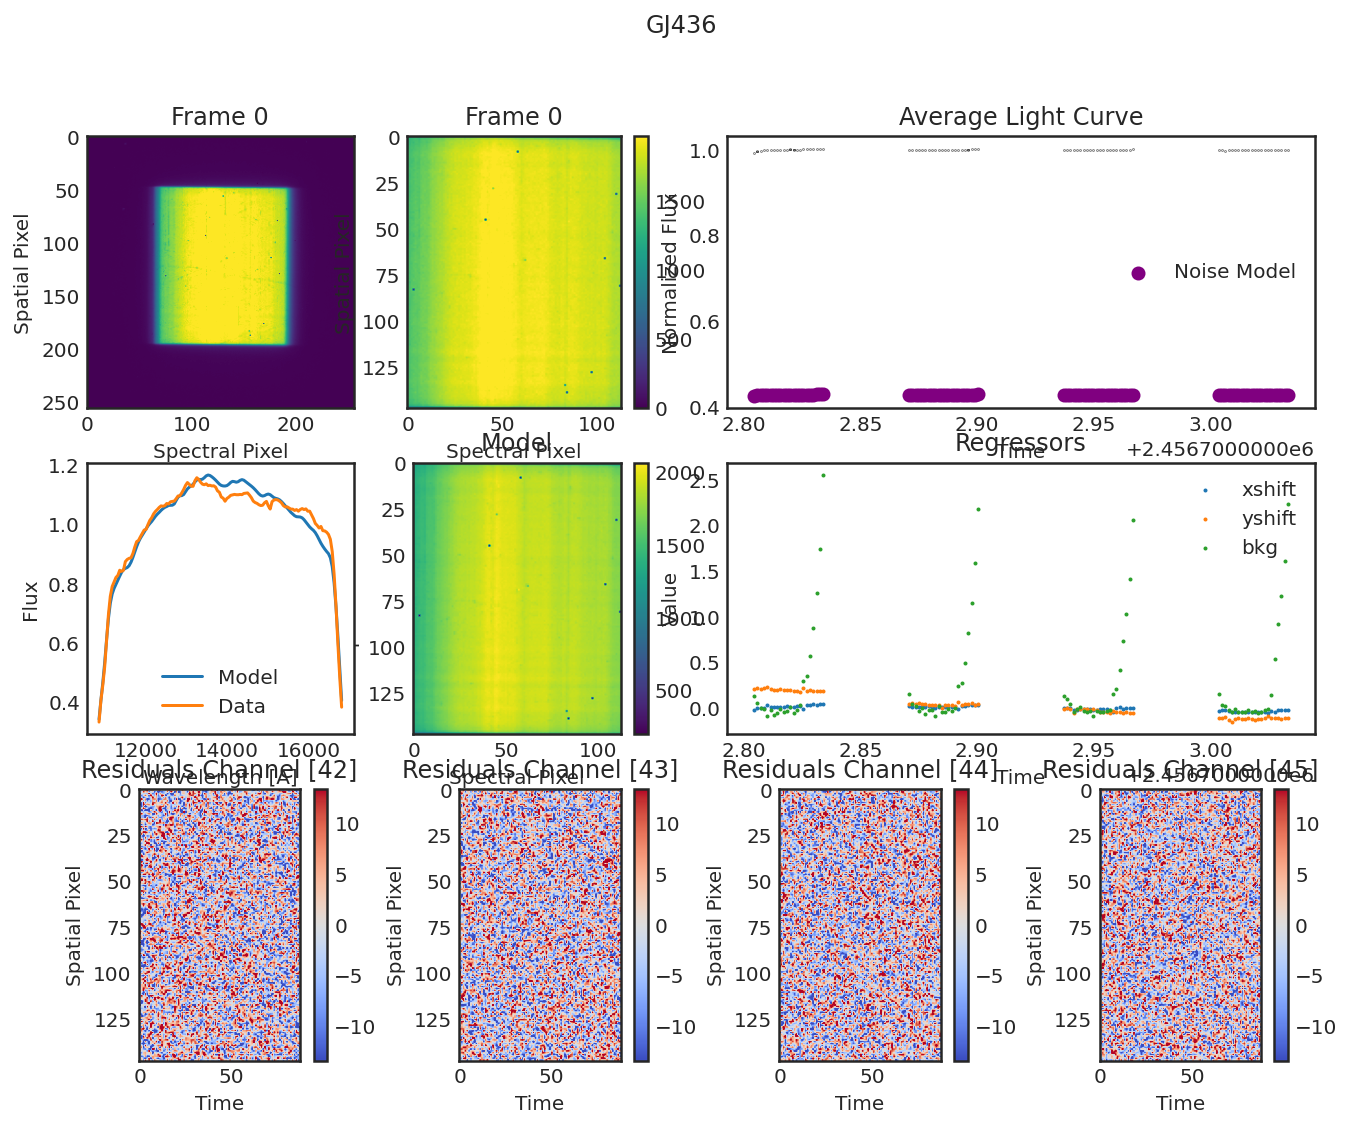

In [17]:
for visit in obs:
    visit.diagnose();
    plt.show();